# Data PreProcessing and generating a csv

# > The data preprocessing will be attached with an other file that was used to clean the text and then the dataset was downloaded. 
# > The name of the file is AG_news_data_preProcess

# Importing all the dependancies 
**The following code was run on kaggle**

In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt

# To import the Transformer Models
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, logging

# to convert to dataset datatype - the transformers library does not work well with pandas
from datasets import Dataset

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ag-news-preprocessed/ag_news_preprocessed.csv
/kaggle/input/reutrls-news-dataset/reuters_preprocessed.csv


# Here the other models are Commented feel free to uncomment one and comment the ther 2 to select your model 

In [2]:
# pretrained_model = "distilbert-base-uncased" 
# pretrained_model = "google/electra-base-discriminator" 
pretrained_model = "bert-base-uncased"

In [9]:
df = pd.read_csv('/kaggle/input/ag-news-preprocessed/ag_news_preprocessed.csv')
from sklearn.preprocessing import LabelEncoder
# encoding the label from string to an integer as the model cannot take in Integer
df['label'] = LabelEncoder().fit_transform(df['label'])
df.head()

,summary,label
0,wall st bears claw back black reuters reuters ...,0
1,carlyle looks toward commercial aerospace reut...,0
2,oil economy cloud stocks outlook reuters reute...,0
3,iraq halts oil exports main southern pipeline ...,0
4,oil prices soar alltime record posing new mena...,0


# Splitting the dataset into 3 parts 
# 1. Train_df: used to train the model 
# 2. val_df : used while training for validation 
# 3. test_df : after the model is trained this dataframe is used to test the model performance parameters

In [10]:
train_df, next_df = train_test_split(df, test_size = 0.70, random_state = 42,stratify=df['label'])


In [11]:
val_df,test_df = train_test_split(next_df, test_size = 0.70, random_state = 42,stratify=next_df['label'])

In [12]:
train_df

,summary,label
97186,clarke gilchrist flay sorry new zealand two da...,2
5023,file sharing companies ruled liable federal ap...,0
115852,zafi worm variant hides behind christmas cheer...,1
100461,chirac arrives libya first ever visit french h...,3
3691,google prices shares washington google closed ...,0
...,...,...
100750,casino forks cheese sandwich hollywood fla onl...,1
94564,american airlines better ontime record fort wo...,0
529,venezuela holds referendum president caracas v...,3
9876,delta halfway restructuring wsj new york reute...,0


# Tokenizer in this process we use a pretrained models Tokenizer that is used to convert our text samples into a large vector that will be fed inside the model 

In [13]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
def preprocess_function(examples):
    """
    Tokenize the text to create input and attention data
    
    in -> dataset (columns = text, label)
    out -> tokenized dataset (columns = text, label, input, attention)
    """
    return tokenizer(examples["summary"], truncation=True)


def pipeline(dataframe):
    """
    Prepares the dataframe so that it can be given to the transformer model
    
    in -> pandas dataframe
    out -> tokenized dataset (columns = text, label, input, attention)
    """    
    # This step isn't mentioned anywhere but is vital as Transformers library only seems to work with this Dataset data type
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('summary')
    return tokenized_ds

In [14]:
tokenized_train = pipeline(train_df)
tokenized_val = pipeline(val_df)

  0%|          | 0/39 [00:00<?, ?ba/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

# Here we set the training aguments based on the dataset and searching accross kaggle and we also train the model here 

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=4)

training_args = TrainingArguments(
    output_dir="./results",
    # important as the standard setting of 500 creates too much data
    save_strategy = 'epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    report_to="none", # Stops transformers from trying to connect to weights and biases site
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

%time trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss
500,0.366600
1000,0.263400
1500,0.222400
2000,0.183300
2500,0.168800
3000,0.126100
3500,0.124200
4000,0.086700
4500,0.086900
5000,0.071000


Saving model checkpoint to ./results/checkpoint-1197
Configuration saved in ./results/checkpoint-1197/config.json
Model weights saved in ./results/checkpoint-1197/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1197/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1197/special_tokens_map.json
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Saving model checkpoint to ./results/checkpoint-2394
Configuration saved in ./results/checkpoint-2394/config.json
Model weights saved in ./results/checkpoint-2394/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-2394/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-2394/special_tokens_map.json
/opt/conda/lib/python3.7/site-packages/torch/nn/p

# Here we are preprocessing the test_df to test our model's performance parameter

In [18]:
tokenized_test = pipeline(test_df)

tokenized_test = tokenized_test.remove_columns('label')

preds = trainer.predict(tokenized_test)

  0%|          | 0/63 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 62524
  Batch size = 32


In [19]:
test_df['label'] = LabelEncoder().fit_transform(test_df['label'])

In [20]:
preds_flat = [np.argmax(x) for x in preds[0]]

len(preds_flat)

62524

# Plot the confusion matrix and other performance parameter for all the 4 classes: World, Sports, Business, and Science/Technology.
# Business           --> 0
# Science/Technology --> 1
# Sports             --> 2
# World              --> 3

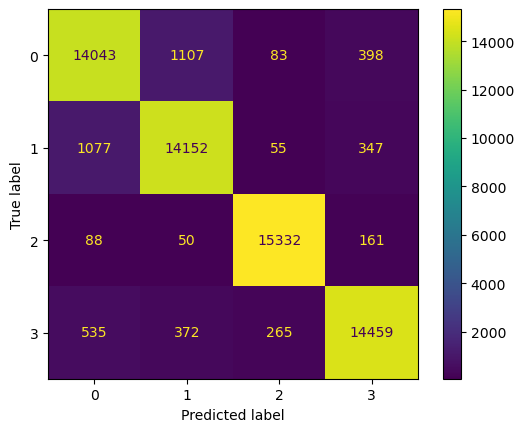

In [21]:
cm = confusion_matrix(test_df['label'], preds_flat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

plt.show()

In [22]:
precision, recall, fscore, support = score(test_df['label'], preds_flat)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.8920155  0.90249346 0.97438831 0.94103482]
recall: [0.89840701 0.90538033 0.98087135 0.92502079]
fscore: [0.89519985 0.90393459 0.97761908 0.93295909]
support: [15631 15631 15631 15631]
